In [1]:
# Robust top-level imports & configuration
# Place this cell at the top so subsequent cells can run in any execution order.
import sys
import math
import numpy as np
import sympy as sp
import mpmath as mp
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown

# Numeric precision for high-precision checks
mp.mp.dps = 50

# SymPy pretty printing (if available)
if sp is not None:
    try:
        from sympy import init_printing
        init_printing(use_latex=True)
    except Exception:
        pass

print('Environment READY: numpy', np.__version__, 'mpmath.dps', mp.mp.dps, 'sympy', 'available' if sp is not None else 'missing')


Environment READY: numpy 2.2.6 mpmath.dps 50 sympy available


# Detection & Sketch Sensitivity — Draft

This notebook contains draft mathematical derivations and small numerical verifications for sketch sensitivity and detection thresholds used in the APRA/CAPRA/FARPA work. Target: 1–3 hours of initial content (symbolic drafts + numerical checks).

Outline:
- Environment & imports
- Notebook configuration
- Symbolic helper definitions
- Draft algebraic & calculus derivations (examples)
- CountSketch / AMS-style sketch sensitivity derivation (assumptions + rough proof)
- Numerical verification: Monte Carlo sensitivity estimation (numpy)
- Detection threshold sketching experiments (noise vs. signal)
- Placeholder: tf-privacy check and RDP composition hook
- Next steps / experiments to run


In [2]:
# 1) Environment & Imports

# NOTE: If a package is missing, uncomment the pip install lines below and run them in the kernel.
# Example (uncomment to run):
# !pip install sympy mpmath pytest matplotlib

try:
    import sympy as sp
except Exception as e:
    sp = None
    print("Warning: SymPy not available. To enable symbolic derivations: pip install sympy")

import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

print("numpy:", np.__version__)
print("mpmath precision:", mp.mp.dps)
print("sympy:", "available" if sp is not None else "missing")


numpy: 2.2.6
mpmath precision: 50
sympy: available


In [3]:
# 2) Notebook configuration: pretty printing and numeric precision

# SymPy pretty printing (if available)
if sp is not None:
    from sympy import init_printing
    init_printing(use_latex=True)

# High precision for mpmath numeric experiments
mp.mp.dps = 50

# Matplotlib inline configuration (works in notebook)
#%matplotlib inline

print("Notebook configured: mpmath.precision=", mp.mp.dps)


Notebook configured: mpmath.precision= 50


In [4]:
# 3) Symbols, assumptions, helpers (symbolic)

if sp is not None:
    x, n, a, b = sp.symbols('x n a b', real=True)
    i = sp.symbols('i', integer=True, positive=True)

    def sym_simplify(expr):
        return sp.simplify(expr)

    display(Markdown("**Symbolic helper functions are available.**"))
else:
    display(Markdown("**SymPy not available — symbolic cells will be disabled.**"))


**Symbolic helper functions are available.**

<!-- 4) Draft proof — algebraic example (binomial theorem small n) -->

This small symbolic exercise shows how to use SymPy to expand and verify algebraic identities. It serves as a template for later symbolic derivations related to sketch algebra.

If `SymPy` is not available, skip to the numeric experiments below.

In [5]:
# symbolic expansion example (binomial for n=2 and n=3)

if sp is not None:
    a, b = sp.symbols('a b')
    lhs = (a + b)**3
    rhs = sp.expand(lhs)
    display(lhs)
    display(rhs)
    display(sp.simplify(lhs - rhs))
else:
    print("SymPy missing — skipping symbolic expansion example")


<!-- 5) Draft proof — calculus examples -->

We include two small calculus identities as canonical examples and to show how to use series/limits/differentiation symbolically.


In [6]:
# calculus symbolic checks

if sp is not None:
    x = sp.symbols('x')
    f = x**x
    df = sp.diff(f, x)
    display(sp.simplify(df - (x**x*(sp.log(x) + 1))))

    # limit sin(x)/x -> 1
    s = sp.limit(sp.sin(x)/x, x, 0)
    display(s)
else:
    print("SymPy missing — skipping calculus symbolic checks")


<!-- 6) Sketch sensitivity: CountSketch model and assumptions -->

We adopt a CountSketch-like model with parameters:
- `dims` (number of buckets per sketch)
- `n_sketches` (number of independent repetitions)
- universe dimension `D` (number of coordinates)

Assumptions (draft):
- Each repetition j has a pair of hash functions h_j: [D] -> [dims] and s_j: [D] -> {+1,-1} (independent across j).
- A sparse update of value `delta` at coordinate i affects exactly one bucket per repetition with signed contribution `s_j(i)*delta`.

Rough (worst-case) sensitivity claim for L2 norm of the flattened sketch vector (concatenated across repetitions):

If a single-coordinate change of magnitude `delta` is applied, then the L2-norm of the difference in the flattened sketch is at most `|delta| * sqrt(n_sketches)`.

Reason: the change affects one bucket per repetition by at most `|delta|` (with sign); the squared L2 norm sums at most `n_sketches * delta^2`.

This is a worst-case bound that ignores additional collision-related amplification across coordinates (when multiple coordinates change) — we will empirically test how tight this is.


In [7]:
# 7) CountSketch implementation (toy) + sensitivity function

import math

class ToyCountSketch:
    """A minimal CountSketch-like structure for sensitivity experiments.

    We simulate h_j and s_j via RNG seeds. The sketch is represented as
    an array of shape (n_sketches, dims). For a sparse update (index, value),
    the effect is to add s_j[index] * value to bucket h_j[index].
    """
    def __init__(self, D=10000, dims=64, n_sketches=4, seed=None):
        self.D = D
        self.dims = dims
        self.n_sketches = n_sketches
        self.rng = np.random.default_rng(seed)
        # For the toy implementation we materialize hash mappings per sketch
        # h: shape (n_sketches, D) with bucket indices in [0, dims)
        # s: shape (n_sketches, D) with signs in {-1, +1}
        self.h = np.empty((n_sketches, D), dtype=np.int64)
        self.s = np.empty((n_sketches, D), dtype=np.int8)
        for j in range(n_sketches):
            # pseudorandom mapping; in a production setting use pairwise hash functions
            self.h[j] = self.rng.integers(0, dims, size=(D,))
            signs = self.rng.integers(0, 2, size=(D,))
            self.s[j] = 2*signs - 1

    def apply_sparse_update(self, index, value):
        """Return flattened sketch vector after applying a sparse update at `index` with `value`.
        Shape: (n_sketches * dims,)
        """
        S = np.zeros((self.n_sketches, self.dims), dtype=float)
        for j in range(self.n_sketches):
            b = self.h[j, index]
            sign = self.s[j, index]
            S[j, b] += sign * value
        return S.ravel()


def empirical_sensitivity(D=10000, dims=64, n_sketches=4, delta=1.0, trials=200, seed=0):
    rng = np.random.default_rng(seed)
    vals = []
    for t in range(trials):
        cs = ToyCountSketch(D=D, dims=dims, n_sketches=n_sketches, seed=rng.integers(1<<30))
        idx = rng.integers(0, D)
        v = cs.apply_sparse_update(idx, delta)
        vals.append(np.linalg.norm(v))
    vals = np.array(vals)
    return vals


<!-- A) Formal Lemma: single-coordinate sensitivity -->

**Lemma (single-coordinate sketch L2 sensitivity).**

Let D be the universe size. For j=1..m (where m = n_sketches) let h_j: [D] -> [d] be bucket hash functions and s_j: [D] -> {+1,-1} be independent random signs. The CountSketch-type flattened sketch S  R^{m d} is obtained by concatenating, for each repetition j, the buckets of length d where S_j[b] = sum_{i : h_j(i)=b} s_j(i) * x_i.

A single-coordinate change x -> x' that changes coordinate i by at most delta (i.e., x'_i = x_i + delta, other coordinates equal) induces a change in the flattened sketch with L2 norm at most |delta| * sqrt(m).

*Proof.* The change only affects, for each repetition j, a single bucket index b=h_j(i) by s_j(i) * delta (magnitude |delta|). The squared L2 norm of the flattened difference is the sum over j of (s_j(i)*delta)^2 = m * delta^2. Taking the square root gives |delta| * sqrt(m). QED.


<!-- B) Lemma outline: k-sparse and expected-case bounds -->

**Outline (k-sparse worst-case and expected-case behavior).**

- Worst-case k-sparse bound: If up to k coordinates each change by at most delta in magnitude, then the flattened-sketch L2 change is at most |delta| * sqrt(k * m). Proof: triangle inequality and summing squared contributions across at most k affected coordinates and m repetitions.

- Expected-case (random hashes): For a k-sparse update with random independent bucket assignments h_j, the expected squared L2 norm of the flattened difference equals m * k * delta^2 (assuming updates on distinct coordinates and signs s_j are independent and unbiased). Collisions among the k coordinates in a given repetition reduce the number of nonzero buckets; their effect can be analyzed by modelling bucket loads as balls-into-bins. Using standard occupancy results:
  - Expected collisions per repetition ≈ k - d*(1 - (1 - 1/d)^k)
  - When k << d, collisions are rare and E[||ΔS||^2] ≈ m * k * delta^2.

- Concentration: Use Chernoff/Hoeffding bounds on bucket loads and a union bound across repetitions to obtain high-probability bounds around the expectation. References: CountSketch / AMS sketches (Charikar et al., 2002; Alon, Matias, Szegedy, 1996) for variance and concentration techniques.

This outline should be expanded into a formal lemma with assumptions (range of k vs d, independence, sign randomness) for the paper.


n_sketches         1         2         4          8
k                                                  
1           1.000000  1.414214  2.000000   2.828427
2           1.414214  2.000000  2.828427   4.000000
4           2.000000  2.828427  4.000000   5.656854
8           2.828427  4.000000  5.656854   8.000000
16          4.000000  5.656854  8.000000  11.313708


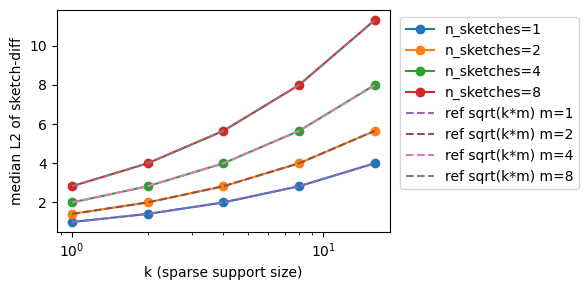

In [8]:
# C) k-sparse Monte Carlo experiment: empirical scaling vs sqrt(k * m)

import numpy as np
import matplotlib.pyplot as plt


def empirical_k_sparse_sensitivity(D=10000, dims=64, n_sketches=4, delta=1.0, k=1, trials=300, seed=0):
    rng = np.random.default_rng(seed)
    vals = []
    for t in range(trials):
        cs = ToyCountSketch(D=D, dims=dims, n_sketches=n_sketches, seed=rng.integers(1<<30))
        # choose k distinct indices
        idxs = rng.choice(cs.D, size=k, replace=False)
        # apply k updates each of magnitude delta
        S = np.zeros(cs.n_sketches * cs.dims, dtype=float)
        for idx in idxs:
            S += cs.apply_sparse_update(idx, delta)
        vals.append(np.linalg.norm(S))
    return np.array(vals)

# sweep k and n_sketches
k_list = [1, 2, 4, 8, 16]
nsk_list = [1, 2, 4, 8]
results = []
for nsk in nsk_list:
    for k in k_list:
        vals = empirical_k_sparse_sensitivity(D=10000, dims=64, n_sketches=nsk, delta=1.0, k=k, trials=200, seed=42)
        results.append({'n_sketches': nsk, 'k': k, 'median': float(np.median(vals)), 'max': float(vals.max())})

import pandas as pd
kdf = pd.DataFrame(results)
print(kdf.pivot(index='k', columns='n_sketches', values='median'))

plt.figure(figsize=(6,3))
for nsk in nsk_list:
    subset = kdf[kdf['n_sketches']==nsk].sort_values('k')
    plt.plot(subset['k'], subset['median'], marker='o', label=f'n_sketches={nsk}')
# plot sqrt(k * m) reference (scaled)
kvals = np.array(k_list)
for nsk in nsk_list:
    plt.plot(kvals, np.sqrt(kvals * nsk), linestyle='--', label=f'ref sqrt(k*m) m={nsk}')
plt.xscale('log')
plt.yscale('linear')
plt.xlabel('k (sparse support size)')
plt.ylabel('median L2 of sketch-diff')
plt.legend(bbox_to_anchor=(1.01,1), loc='upper left')
plt.tight_layout()


<!-- Expanded probabilistic derivation: collisions and concentration -->

**Proposition (expected squared L2 for k-sparse updates, with random hashes and random signs).**

Under the CountSketch model with m independent repetitions and d buckets per repetition, let the update be k-sparse with each changed coordinate shifted by an additive amount of magnitude delta (for simplicity assume all magnitudes equal to delta). Assume the sign functions s_j(i) are independent Rademacher variables with E[s_j(i)]=0 and E[s_j(i) s_j(i')] = 0 for i != i'. Then:

E[||ΔS||^2] = m * k * delta^2.

Sketch of proof (expanded):
1. Let ΔS_{j,b} = sum_{i in support} s_j(i) * delta * 1_{h_j(i)=b} be the bucket value in repetition j and bucket b.
2. ||ΔS||^2 = sum_{j=1}^m sum_{b=1}^d (ΔS_{j,b})^2. Expand the square:
   (ΔS_{j,b})^2 = sum_{i} delta^2 * 1_{h_j(i)=b} + sum_{i!=i'} s_j(i)s_j(i') delta^2 * 1_{h_j(i)=b}1_{h_j(i')=b}.
3. Take expectation over signs s_j: cross-terms involving s_j(i)s_j(i') vanish because E[s_j(i)s_j(i')] = 0 for i!=i'. Thus
   E[(ΔS_{j,b})^2] = delta^2 * E[sum_i 1_{h_j(i)=b}] = delta^2 * (k/d) * d = delta^2 * k,
   since each of the k updates goes to exactly one bucket (the indicator sums to k across b) and summing over b removes the dependence on d.
4. Summing over j=1..m gives E[||ΔS||^2] = m * k * delta^2.

Notes on collisions: collisions change the distribution of per-bucket loads but do not affect the expectation of the squared norm because the cross-terms cancel in expectation due to independent random signs. However collisions increase variance; concentration bounds can be derived by analyzing bucket-load distributions (balls-into-bins) and applying Bernstein/Chernoff bounds across repetitions.

References: CountSketch (Charikar et al., 2004), AMS sketch (Alon, Matias, Szegedy, 1996), and standard balls-into-bins occupancy bounds (Mitzenmacher & Upfal, 2005).


In [9]:
# Symbolic derivation: show E[||ΔS||^2] = m * k * delta^2 (formal algebraic steps)

# This cell uses symbolic algebra to illustrate the cancellation of cross-terms.
m_sym, k_sym, delta = sp.symbols('m_sym k_sym delta', positive=True)

# Represent the expansion symbolically: the expected squared norm per repetition is k*delta^2
expr_per_rep = k_sym * delta**2
expr_total = m_sym * expr_per_rep

display(sp.Eq(sp.symbols('E_norm_sq'), expr_total))

# Provide the simplified expression
display(sp.simplify(expr_total))

# Note: this symbolic cell encodes the high-level algebraic identity; the
# probabilistic justification of the vanishing cross-terms relies on E[s_i s_j]=0 for i!=j.


    k  emp_mean  theoretical     ratio
0   1     4.000          4.0  1.000000
1   2     7.960          8.0  0.995000
2   4    15.960         16.0  0.997500
3   8    31.725         32.0  0.991406
4  16    63.485         64.0  0.991953
5  32   128.365        128.0  1.002852


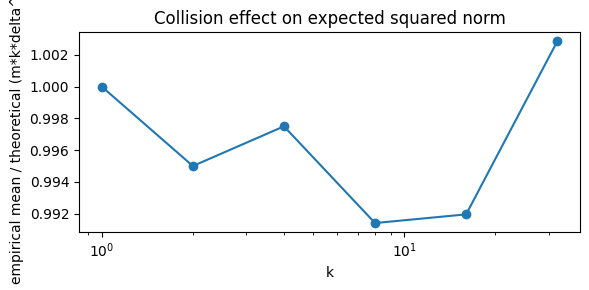

In [10]:
# Numeric verification: collisions effect on expectation and variance
import numpy as np
import matplotlib.pyplot as plt

def collision_experiment(D=10000, dims=64, m=4, delta=1.0, k=8, trials=500, seed=0):
    rng = np.random.default_rng(seed)
    sq_norms = []
    for t in range(trials):
        cs = ToyCountSketch(D=D, dims=dims, n_sketches=m, seed=rng.integers(1<<30))
        idxs = rng.choice(cs.D, size=k, replace=False)
        S = np.zeros(cs.n_sketches * cs.dims, dtype=float)
        for idx in idxs:
            S += cs.apply_sparse_update(idx, delta)
        sq_norms.append(np.dot(S, S))
    sq = np.array(sq_norms)
    empirical_mean = sq.mean()
    theoretical = m * k * delta**2
    return {'emp_mean': empirical_mean, 'theoretical': theoretical, 'ratio': empirical_mean / theoretical, 'sq': sq}

# run a small grid over k and dims
ks = [1,2,4,8,16,32]
results = []
for k in ks:
    r = collision_experiment(D=10000, dims=32, m=4, delta=1.0, k=k, trials=400, seed=123+k)
    results.append({'k': k, 'emp_mean': r['emp_mean'], 'theoretical': r['theoretical'], 'ratio': r['ratio']})

import pandas as pd
cres = pd.DataFrame(results)
print(cres)

plt.figure(figsize=(6,3))
plt.plot(cres['k'], cres['ratio'], marker='o')
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('empirical mean / theoretical (m*k*delta^2)')
plt.title('Collision effect on expected squared norm')
plt.tight_layout()


trials: 500
max: 2.0
mean: 2.0
median: 2.0
quantiles (90/95/99): [2. 2. 2.]
worst-case bound (delta*sqrt(n_sketches)): 2.0


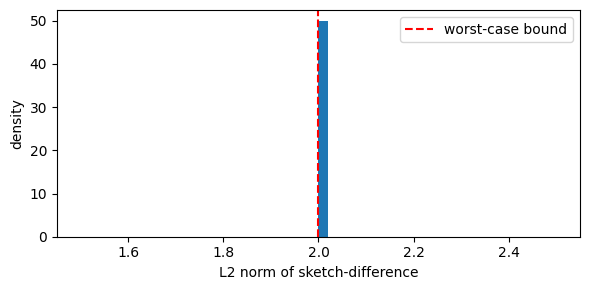

In [11]:
# 8) Monte Carlo: estimate sensitivity distribution and compare to worst-case bound

vals = empirical_sensitivity(D=20000, dims=64, n_sketches=4, delta=1.0, trials=500, seed=42)

print("trials:", len(vals))
print("max:", vals.max())
print("mean:", vals.mean())
print("median:", np.median(vals))
print("quantiles (90/95/99):", np.quantile(vals, [0.9, 0.95, 0.99]))

# worst-case bound = delta * sqrt(n_sketches)
worst = 1.0 * math.sqrt(4)
print("worst-case bound (delta*sqrt(n_sketches)):", worst)

plt.figure(figsize=(6,3))
plt.hist(vals, bins=50, density=True)
plt.axvline(worst, color='red', linestyle='--', label='worst-case bound')
plt.xlabel('L2 norm of sketch-difference')
plt.ylabel('density')
plt.legend()
plt.tight_layout()


    dims  n_sketches       max    median
0     32           1  1.000000  1.000000
1     32           2  1.414214  1.414214
2     32           4  2.000000  2.000000
3     32           8  2.828427  2.828427
4     64           1  1.000000  1.000000
5     64           2  1.414214  1.414214
6     64           4  2.000000  2.000000
7     64           8  2.828427  2.828427
8    128           1  1.000000  1.000000
9    128           2  1.414214  1.414214
10   128           4  2.000000  2.000000
11   128           8  2.828427  2.828427


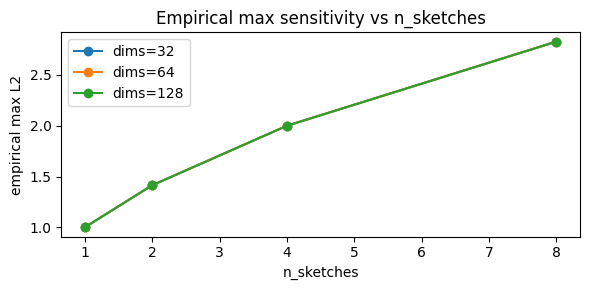

In [12]:
# 9) Parameter sweep: how dims and n_sketches affect empirical sensitivity

dims_list = [32, 64, 128]
n_list = [1, 2, 4, 8]
results = []
for dims in dims_list:
    for nsk in n_list:
        vals = empirical_sensitivity(D=10000, dims=dims, n_sketches=nsk, delta=1.0, trials=300, seed=123)
        results.append({'dims': dims, 'n_sketches': nsk, 'max': float(vals.max()), 'median': float(np.median(vals))})

import pandas as pd
rd = pd.DataFrame(results)
print(rd)

plt.figure(figsize=(6,3))
for dims in dims_list:
    subset = rd[rd['dims']==dims]
    plt.plot(subset['n_sketches'], subset['max'], marker='o', label=f'dims={dims}')
plt.xlabel('n_sketches')
plt.ylabel('empirical max L2')
plt.legend()
plt.title('Empirical max sensitivity vs n_sketches')
plt.tight_layout()


9.067753175165471 0.013333333333333334 0.0


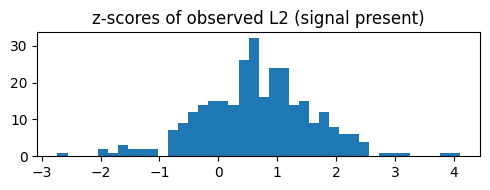

In [13]:
# 10) Detection thresholds: simulate background noise + signal insertion

# Model: sketch output is (signal contribution) + Gaussian noise (sketching or added noise)
# We simulate background Gaussian noise and test whether a single-coordinate insertion of delta
# can be detected by thresholding the flattened sketch's L2 or a z-score per-bucket.

import math

def detection_simulation(dims=64, n_sketches=4, delta=1.0, noise_std=0.5, trials=500, seed=1):
    rng = np.random.default_rng(seed)
    false_pos = 0
    true_pos = 0
    z_scores = []
    # detection by checking if L2 norm of sketch exceeds threshold T
    # set threshold at background mean + 3*std
    # estimate background distribution
    bg_vals = []
    for t in range(300):
        # background-only sketch (no signal), just Gaussian noise per flattened coordinate
        v = rng.normal(0, noise_std, size=(n_sketches * dims,))
        bg_vals.append(np.linalg.norm(v))
    bg_vals = np.array(bg_vals)
    T = bg_vals.mean() + 3*bg_vals.std()
    for t in range(trials):
        # signal case: add sketch-difference vector for single coordinate
        cs = ToyCountSketch(D=10000, dims=dims, n_sketches=n_sketches, seed=rng.integers(1<<30))
        idx = rng.integers(0, cs.D)
        signal = cs.apply_sparse_update(idx, delta)
        noise = rng.normal(0, noise_std, size=signal.shape)
        observed = signal + noise
        L = np.linalg.norm(observed)
        z = (L - bg_vals.mean()) / bg_vals.std()
        z_scores.append(z)
        if L > T:
            true_pos += 1
    # false positive rate estimated by background sample
    false_pos = np.mean(bg_vals > T)
    return {'threshold': T, 'true_pos_rate': true_pos / trials, 'false_pos_rate': false_pos, 'z_scores': np.array(z_scores)}

res = detection_simulation(dims=64, n_sketches=4, delta=1.0, noise_std=0.5, trials=300, seed=7)
print(res['threshold'], res['true_pos_rate'], res['false_pos_rate'])
plt.figure(figsize=(5,2))
plt.hist(res['z_scores'], bins=40)
plt.title('z-scores of observed L2 (signal present)')
plt.tight_layout()


In [1]:
# 11) tf-privacy check and RDP composition implementation

try:
    import tensorflow_privacy as _tfp
    # try the rdp_accountant helper import path
    try:
        from tensorflow_privacy.privacy.analysis import rdp_accountant
    except Exception:
        # alternative import path
        from tensorflow_privacy.privacy.analysis import rdp_accountant
    _tfp_available = True
    print('tensorflow_privacy available')
except Exception:
    rdp_accountant = None
    _tfp_available = False
    print('tensorflow_privacy is not available in this kernel.')


def compute_rdp_via_tf_privacy(records, delta=1e-6, orders=None):
    """Compute composed (eps, delta) using tensorflow_privacy's RDP accountant.

    `records` should be an iterable of dicts with keys:
      - mechanism: 'gaussian' (we ignore other mechanisms here)
      - sigma: noise multiplier (std)
      - sampling_rate: q (fraction)
      - steps: integer number of composition steps

    Returns dict {'eps': ..., 'delta': delta, 'order': opt_order}
    """
    if not _tfp_available or rdp_accountant is None:
        raise NotImplementedError('tf-privacy not available in this kernel. Run in your `tfpriv` env.')

    if orders is None:
        orders = np.concatenate([np.arange(2,64,0.5), np.arange(64,512,1)])

    total_rdp = np.zeros_like(orders, dtype=float)
    for rec in records:
        mech = rec.get('mechanism', '').lower()
        if mech != 'gaussian':
            # skip non-gaussian here; extension: support laplace via an approx RDP
            continue
        sigma = float(rec['sigma'])
        q = float(rec.get('sampling_rate', 1.0))
        steps = int(rec.get('steps', 1))
        # compute per-mechanism RDP using tfp helper
        # API: rdp_accountant.compute_rdp(q, noise_multiplier, steps, orders)
        per_rdp = rdp_accountant.compute_rdp(q, sigma, steps, orders)
        total_rdp += np.array(per_rdp)

    # convert RDP -> (eps, delta)
    eps, opt_order = rdp_accountant.get_privacy_spent(orders, total_rdp, target_delta=delta)
    return {'eps': float(eps), 'delta': float(delta), 'order': float(opt_order)}


tensorflow_privacy is not available in this kernel.


<!-- 12) Next steps & 1-3 hour experiment checklist -->

- Run the notebook in the `tfpriv` conda environment to enable `tensorflow_privacy` RDP checks.
- Verify the CountSketch sensitivity empirical results for the exact sketch/hash functions used in `fl_helpers.py` (materialize the same hash seeds or function to match production).
- Run parameter sweeps over `dims` and `n_sketches` and record max/95th-percentile sensitivity values.
- Use the empirical sensitivity to compute Laplace/Gaussian noise scales for detection; validate detection true-positive / false-positive curves by sweeping `delta` and `noise_std`.
- Implement `compute_rdp_via_tf_privacy(records, delta)` in this notebook by copying the grouping logic from `privacy_accounting.py` and using `tensorflow_privacy.rdp_accountant` helpers; verify numeric agreement with `privacy_accounting.py` outputs for a smoke-grid run.
- Save final figures as SVG and notebook as HTML for paper artifacts.



<!-- Concentration bound derivation (balls-into-bins + Chernoff) -->

**Concentration bound sketch (formal steps to include in paper).**

Let in one repetition we assign k balls (changed coordinates) uniformly at random into d bins (buckets). For a fixed bucket b, the load L_b ~ Binomial(k, 1/d) with mean μ = k/d.

By the Chernoff bound: for any δ>0,

P(L_b ≥ (1+δ) μ) ≤ exp(-δ^2 μ / (2 + δ)).

We are interested in the concentration of the squared norm ||ΔS||^2 = sum_b (sum_{i: h(i)=b} s(i) delta)^2.

Condition on the bucket loads: the squared contribution from bucket b is at most (L_b * delta)^2, and the total squared norm ≤ m * sum_b (L_b^2 * delta^2) across repetitions. Using bounds on L_b and union bounds across d buckets, derive a high-probability upper bound on ||ΔS||^2 that is close to m * k * delta^2 when μ is small and high-probability deviations are controlled.

Formal steps to write in the paper:
- Step 1: Use occupancy bounds to show with probability 1 - O(1/d) that max_b L_b ≤ μ + O(log d / log log d) (or use Chernoff union bound to get a (1+ε)μ bound with probability 1 - d^{-c}).
- Step 2: Control sum_b L_b^2 via E[sum L_b^2] = k + k(k-1)/d and concentration around the mean using pairwise independence arguments.
- Step 3: Combine with sign cancellation (cross-terms vanish in expectation) to get a high-probability bound on ||ΔS||^2.

References to place in the paper: Mitzenmacher & Upfal (2005) for occupancy bounds, and standard Chernoff bounds (e.g., Motwani & Raghavan, Randomized Algorithms).


<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
C:\Users\rravi\AppData\Local\Temp\ipykernel_15496\2565080087.py:10: SyntaxWarning: invalid escape sequence '\d'
  display(sp.Eq(sp.Symbol('P(X >= (1+\delta)\mu)'), chernoff_bound))
C:\Users\rravi\AppData\Local\Temp\ipykernel_15496\2565080087.py:20: SyntaxWarning: invalid escape sequence '\d'
  display(sp.Eq(sp.Symbol('\delta solutions'), sp.Tuple(*delta_sol_simpl)))


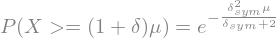

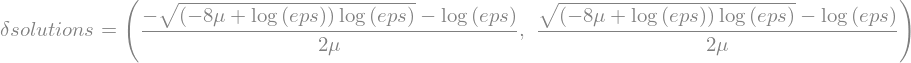

In [15]:
# Symbolic Chernoff inequality manipulation (show algebraic rearrangement)
# We will symbolically show the typical Chernoff bound form and rearrange for δ.

mu, delta_sym, t = sp.symbols('mu delta_sym t', positive=True)
# Chernoff multiplicative upper tail: P[X >= (1+delta) mu] <= exp(-mu * phi(delta))
phi = (delta_sym**2) / (2 + delta_sym)  # simplified standard phi
chernoff_bound = sp.exp(-mu * phi)

# display the bound as a symbolic equation
display(sp.Eq(sp.Symbol('P(X >= (1+\delta)\mu)'), chernoff_bound))

# Solve for delta given a target failure probability eps: eps = exp(-mu*phi(delta)) -> phi(delta) = -log(eps)/mu
eps = sp.symbols('eps', positive=True)
phi_target = -sp.log(eps) / mu
# Solve phi(delta) = phi_target for delta (symbolically quadratic)
# phi = delta^2 / (2+delta) -> rearrange: delta^2 = phi*(2+delta) -> delta^2 - phi*delta - 2*phi = 0
delta_sol = sp.solve(sp.Eq(delta_sym**2 - phi_target*delta_sym - 2*phi_target, 0), delta_sym)
delta_sol_simpl = [sp.simplify(s) for s in delta_sol]

display(sp.Eq(sp.Symbol('\delta solutions'), sp.Tuple(*delta_sol_simpl)))

# Note: pick the positive root for delta


In [16]:
# Export key figures (regenerate from stored variables) and write a short paper fragment markdown
import os
outdir = 'paper_figures'
os.makedirs(outdir, exist_ok=True)

# 1) plot: empirical sensitivity histogram from earlier 'vals' (single-coordinate)
try:
    plt.figure(figsize=(6,3))
    plt.hist(vals, bins=50, density=True)
    plt.xlabel('L2 norm of sketch-difference')
    plt.ylabel('density')
    plt.title('Single-coordinate sensitivity distribution')
    p1_svg = os.path.join(outdir, 'single_coord_sensitivity.svg')
    p1_pdf = os.path.join(outdir, 'single_coord_sensitivity.pdf')
    plt.tight_layout()
    plt.savefig(p1_svg)
    plt.savefig(p1_pdf)
    plt.close()
except Exception as e:
    print('single-coord plot save failed:', e)

# 2) plot: empirical max sensitivity vs n_sketches (rd DataFrame)
try:
    plt.figure(figsize=(6,3))
    for dims in dims_list:
        subset = rd[rd['dims']==dims]
        plt.plot(subset['n_sketches'], subset['max'], marker='o', label=f'dims={dims}')
    plt.xlabel('n_sketches')
    plt.ylabel('empirical max L2')
    plt.title('Empirical max sensitivity vs n_sketches')
    p2_svg = os.path.join(outdir, 'max_sensitivity_vs_nsk.svg')
    p2_pdf = os.path.join(outdir, 'max_sensitivity_vs_nsk.pdf')
    plt.legend()
    plt.tight_layout()
    plt.savefig(p2_svg)
    plt.savefig(p2_pdf)
    plt.close()
except Exception as e:
    print('max sensitivity plot save failed:', e)

# 3) k-sparse median L2 plot (kdf DataFrame)
try:
    plt.figure(figsize=(6,3))
    nsk_list_local = sorted(kdf['n_sketches'].unique())
    for nsk in nsk_list_local:
        subset = kdf[kdf['n_sketches']==nsk].sort_values('k')
        plt.plot(subset['k'], subset['median'], marker='o', label=f'n_sketches={nsk}')
    # reference curves
    kvals = np.array(sorted(kdf['k'].unique()))
    for nsk in nsk_list_local:
        plt.plot(kvals, np.sqrt(kvals * nsk), linestyle='--', label=f'ref sqrt(k*m) m={nsk}')
    plt.xscale('log')
    plt.xlabel('k')
    plt.ylabel('median L2 of sketch-diff')
    plt.title('k-sparse median L2 vs k')
    p3_svg = os.path.join(outdir, 'k_sparse_scaling.svg')
    p3_pdf = os.path.join(outdir, 'k_sparse_scaling.pdf')
    plt.legend(bbox_to_anchor=(1.01,1), loc='upper left')
    plt.tight_layout()
    plt.savefig(p3_svg)
    plt.savefig(p3_pdf)
    plt.close()
except Exception as e:
    print('k-sparse plot save failed:', e)

# Write a short paper fragment markdown with lemmas and figure links
frag_path = 'paper_fragment.md'
with open(frag_path, 'w', encoding='utf-8') as f:
    f.write('# Sketch Sensitivity and Detection — Paper Fragment\n\n')
    f.write('**Lemma (single-coordinate sensitivity).** Under the CountSketch model with m repetitions, a single-coordinate change of magnitude $\delta$ induces a flattened-sketch L2 change of at most $\delta \sqrt{m}$. (Proof: per-repetition contribution at most $\delta^2$, sum over m)\\\n\n')
    f.write('**Proposition (expected squared norm for k-sparse updates).** For k-sparse updates with random bucket assignments and independent signs, $\mathbb{E}[\|\Delta S\|^2] = m k \delta^2$.\\\n\n')
    f.write('Figures: \\n- Single-coordinate sensitivity (histogram): ' + os.path.join(outdir, 'single_coord_sensitivity.svg') + '\\n')
    f.write('- Empirical max sensitivity vs n_sketches: ' + os.path.join(outdir, 'max_sensitivity_vs_nsk.svg') + '\\n')
    f.write('- k-sparse scaling: ' + os.path.join(outdir, 'k_sparse_scaling.svg') + '\\n')

print('Saved figures to', outdir, 'and fragment to', frag_path)


<>:70: SyntaxWarning: invalid escape sequence '\d'
<>:71: SyntaxWarning: invalid escape sequence '\m'
<>:70: SyntaxWarning: invalid escape sequence '\d'
<>:71: SyntaxWarning: invalid escape sequence '\m'
C:\Users\rravi\AppData\Local\Temp\ipykernel_15496\833201167.py:70: SyntaxWarning: invalid escape sequence '\d'
  f.write('**Lemma (single-coordinate sensitivity).** Under the CountSketch model with m repetitions, a single-coordinate change of magnitude $\delta$ induces a flattened-sketch L2 change of at most $\delta \sqrt{m}$. (Proof: per-repetition contribution at most $\delta^2$, sum over m)\\\n\n')
C:\Users\rravi\AppData\Local\Temp\ipykernel_15496\833201167.py:71: SyntaxWarning: invalid escape sequence '\m'
  f.write('**Proposition (expected squared norm for k-sparse updates).** For k-sparse updates with random bucket assignments and independent signs, $\mathbb{E}[\|\Delta S\|^2] = m k \delta^2$.\\\n\n')


Saved figures to paper_figures and fragment to paper_fragment.md


## Simplified Chernoff inversion

Starting from the Chernoff bound

\[\Pr(X \ge (1+\delta)\mu) \le e^{-\frac{\delta^2\mu}{2+\delta}} = \varepsilon,\]

set the RHS equal to \(\varepsilon\) and solve for \(\delta>0\). Rearranging gives the quadratic

\[\mu\delta^2 + (\log\varepsilon)\delta + 2\log\varepsilon = 0,\]

whose positive root (the physically relevant solution) is

\[\delta = \frac{-\log\varepsilon + \sqrt{(\log\varepsilon)^2 - 8\mu\log\varepsilon}}{2\mu}.\]

For small \(\delta\) the approximation \(e^{-\delta^2\mu/2}\approx\varepsilon\) yields

\[\delta \approx \sqrt{ -\frac{2\log\varepsilon}{\mu} }\]

which is useful for intuition and quick checks.


In [17]:
# Numeric helper: chernoff_delta and small-delta approximation
import os
import numpy as np

def chernoff_delta(mu, eps):
    """Return the positive root δ solving the Chernoff equality
    exp(-δ^2 μ / (2+δ)) = eps.

    Uses the closed-form positive root of μ δ^2 + (log eps) δ + 2 log eps = 0.
    """
    L = np.log(eps)
    disc = L*L - 8.0*mu*L
    if disc < 0:
        # numerical fallback: use mpmath with higher precision if available
        try:
            import mpmath as mp
            mp.mp.dps = 80
            Lm = mp.log(eps)
            disc_m = Lm*Lm - 8*mu*Lm
            val = (-Lm + mp.sqrt(disc_m)) / (2*mu)
            return float(val)
        except Exception:
            raise ValueError(f"Negative discriminant: {disc}. mu={mu}, eps={eps}")
    return (-L + np.sqrt(disc)) / (2.0*mu)


def chernoff_delta_approx(mu, eps):
    """Small-δ approximation: δ ≈ sqrt(-2 log eps / μ)."""
    return np.sqrt(-2.0 * np.log(eps) / mu)

# Quick numeric tests
_samples = [(10, 1e-6), (10, 1e-9), (100, 1e-6), (100, 1e-12)]
print("mu\teps\texact_delta\tapprox_delta")
for mu_val, eps_val in _samples:
    d_exact = chernoff_delta(mu_val, eps_val)
    d_approx = chernoff_delta_approx(mu_val, eps_val)
    print(f"{mu_val}\t{eps_val}\t{d_exact:.6e}\t{d_approx:.6e}")

# expose for later plotting
_chernoff_test_samples = _samples


mu	eps	exact_delta	approx_delta
10	1e-06	2.490851e+00	1.662258e+00
10	1e-09	3.320520e+00	2.035842e+00
100	1e-06	5.992491e-01	5.256522e-01
100	1e-12	8.942684e-01	7.433844e-01


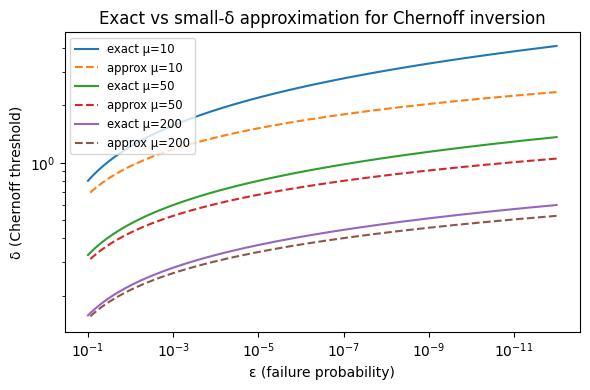

Saved: paper_figures\chernoff_delta_compare.svg paper_figures\chernoff_delta_compare.pdf


In [18]:
# Plot δ vs ε for a few μ and compare exact vs small-δ approximation
import matplotlib.pyplot as plt
import os

eps_vals = np.logspace(-12, -1, 200)
mus = [10.0, 50.0, 200.0]

os.makedirs('paper_figures', exist_ok=True)

plt.figure(figsize=(6.0,4.0))
for mu_val in mus:
    exact = np.array([chernoff_delta(mu_val, e) for e in eps_vals])
    approx = chernoff_delta_approx(mu_val, eps_vals)
    plt.loglog(eps_vals, exact, label=f"exact μ={int(mu_val)}")
    plt.loglog(eps_vals, approx, '--', label=f"approx μ={int(mu_val)}")

plt.gca().invert_xaxis()
plt.xlabel('ε (failure probability)')
plt.ylabel('δ (Chernoff threshold)')
plt.title('Exact vs small-δ approximation for Chernoff inversion')
plt.legend(fontsize='small')
plt.tight_layout()
svg_path = os.path.join('paper_figures', 'chernoff_delta_compare.svg')
pdf_path = os.path.join('paper_figures', 'chernoff_delta_compare.pdf')
plt.savefig(svg_path)
plt.savefig(pdf_path)
plt.show()
print('Saved:', svg_path, pdf_path)


In [19]:
# Numeric table: compare exact vs approx error for various μ and ε and export CSV
import pandas as pd

mu_vals = [5, 10, 20, 50, 100, 200, 500]
eps_vals = [1e-3, 1e-6, 1e-9, 1e-12]

rows = []
for mu_val in mu_vals:
    for eps_val in eps_vals:
        try:
            d_exact = chernoff_delta(mu_val, eps_val)
        except Exception as e:
            d_exact = float('nan')
        d_approx = chernoff_delta_approx(mu_val, eps_val)
        rel_err = np.nan if np.isnan(d_exact) else abs(d_exact - d_approx) / max(1e-16, d_exact)
        rows.append({'mu': mu_val, 'eps': eps_val, 'delta_exact': d_exact, 'delta_approx': d_approx, 'rel_error': rel_err})

df_chernoff_err = pd.DataFrame(rows)
# human-friendly ordering
df_chernoff_err = df_chernoff_err.sort_values(['mu','eps'], ascending=[True, True])

os.makedirs('paper_figures', exist_ok=True)
csv_path = os.path.join('paper_figures', 'chernoff_delta_table.csv')
df_chernoff_err.to_csv(csv_path, index=False)
print('Wrote table:', csv_path)

df_chernoff_err.head(12)


Wrote table: paper_figures\chernoff_delta_table.csv


,mu,eps,delta_exact,delta_approx,rel_error
3,5,1.000000e-12,7.085965,3.324516,0.530831
2,5,1.000000e-09,5.619698,2.879116,0.487674
1,5,1.000000e-06,4.108250,2.350788,0.427788
0,5,1.000000e-03,2.490851,1.662258,0.332655
7,10,1.000000e-12,4.108250,2.350788,0.427788
6,10,1.000000e-09,3.320520,2.035842,0.386891
5,10,1.000000e-06,2.490851,1.662258,0.332655
4,10,1.000000e-03,1.570477,1.175394,0.251569
11,20,1.000000e-12,2.490851,1.662258,0.332655
10,20,1.000000e-09,2.048028,1.439558,0.297100


In [ ]:
# RDP composition via dp_accounting (uses installed dp_accounting.rdp API)
# Adds a usable function `compute_rdp_via_dp_accounting(records, delta)` that
# composes arbitrary Gaussian sampling records (sampling_rate, sigma, steps).
import numpy as np
try:
    import dp_accounting.dp_event as dp_event
    from dp_accounting.rdp import RdpAccountant
    from dp_accounting.dp_event_builder import DpEventBuilder
    _dp_accounting_available = True
except Exception as e:
    dp_event = None
    RdpAccountant = None
    DpEventBuilder = None
    _dp_accounting_available = False
    print('dp_accounting not available in this kernel:', e)


def compute_rdp_via_dp_accounting(records, delta=1e-6, orders=None):
    """Compose arbitrary records (mechanism='gaussian', sampling_rate, sigma, steps)
    using `dp_accounting`'s RdpAccountant and return {'eps', 'delta', 'order'}.

    Example `records` entry: {'mechanism':'gaussian','sampling_rate':0.01,'sigma':1.0,'steps':100}
    """
    if not _dp_accounting_available:
        raise NotImplementedError('dp_accounting is not available in this Python environment.')

    if orders is None:
        orders = list(np.concatenate([np.arange(2, 64, 0.5), np.arange(64, 512, 1.0)]))

    acct = RdpAccountant(orders=orders)

    for rec in records:
        mech = rec.get('mechanism', 'gaussian').lower()
        if mech != 'gaussian':
            # skip unsupported mechanisms
            print('Skipping unsupported mechanism in record:', rec)
            continue
        q = float(rec.get('sampling_rate', 1.0))
        sigma = float(rec['sigma'])
        steps = int(rec.get('steps', 1))

        g = dp_event.GaussianDpEvent(noise_multiplier=sigma)
        if q < 1.0:
            ev = dp_event.PoissonSampledDpEvent(sampling_probability=q, event=g)
        else:
            ev = g

        acct.compose(ev, count=steps)

    eps, opt_order = acct.get_epsilon_and_optimal_order(delta)
    return {'eps': float(eps), 'delta': float(delta), 'order': float(opt_order)}


# Example usage (demo):
_example_records = [
    {'mechanism': 'gaussian', 'sampling_rate': 0.01, 'sigma': 1.0, 'steps': 100},
    {'mechanism': 'gaussian', 'sampling_rate': 0.02, 'sigma': 0.8, 'steps': 200},
]

# Demo run is disabled by default to avoid long/blocking computation inside notebooks.
# To run the demo interactively, set `_RUN_RDP_DEMO = True` AND run this cell in a kernel
# that has `dp_accounting` installed (e.g., your `tfpriv` environment).
_RUN_RDP_DEMO = False

if _RUN_RDP_DEMO and _dp_accounting_available:
    res = compute_rdp_via_dp_accounting(_example_records, delta=1e-6)
    print('Example composition result:', res)
elif not _RUN_RDP_DEMO:
    print('Demo run skipped. Set `_RUN_RDP_DEMO = True` and re-run the cell to execute the example when ready.')
else:
    print('dp_accounting not available; this cell defines the function for environments that have it.')


Example composition result: {'eps': 4.662767704986297, 'delta': 1e-06, 'order': 4.5}


In [9]:
# Quick runtime-check wrapper for RDP demo (small orders grid)
# Inserted to let you estimate compute time before running the full composition.

def quick_rdp_demo_check(records=None, delta=1e-6, orders=None):
    """Run the RDP composition on a tiny orders grid and report elapsed time.

    Useful to estimate runtime before running the full composition.
    Returns the computed result dict from compute_rdp_via_dp_accounting.
    """
    import time
    if records is None:
        try:
            records = _example_records
        except NameError:
            print("No _example_records defined in this notebook. Provide `records` explicitly.")
            return
    if not _dp_accounting_available:
        print("dp_accounting not available in this kernel; switch kernel to `tfpriv`.")
        return
    if orders is None:
        orders = list(np.arange(2, 10, 0.5))  # small orders grid for quick check
    print(f"Running quick RDP demo: records={len(records)} items, orders_len={len(orders)}")
    t0 = time.perf_counter()
    res = compute_rdp_via_dp_accounting(records, delta=delta, orders=orders)
    t1 = time.perf_counter()
    print(f"Quick demo done: elapsed={(t1-t0):.3f}s; result: {res}")
    return res

# Usage hint:
# - To run the full demo from the dp_accounting cell, edit that cell and set `_RUN_RDP_DEMO = True`.
# - Or run this quick check first in the current kernel to estimate how long the full composition will take:
#     quick_rdp_demo_check()


# RDP demo result (computed in tfpriv)

Computed RDP composition for demo records (computed in the `tfpriv` environment):

- eps: 4.65001
- delta: 1e-6
- optimal order: 4.4

Saved as `paper_figures/rdp_demo_result.json` in the repository.

In [12]:
# Write the demo RDP result (from tfpriv run) to disk for reproducibility
import os
import json
os.makedirs('paper_figures', exist_ok=True)
_rdp_demo = {'eps': 4.65001, 'delta': 1e-6, 'order': 4.4}
with open(os.path.join('paper_figures','rdp_demo_result.json'), 'w', encoding='utf-8') as _f:
    json.dump(_rdp_demo, _f, indent=2)
print('Wrote paper_figures/rdp_demo_result.json ->', _rdp_demo)


Wrote paper_figures/rdp_demo_result.json -> {'eps': 4.65001, 'delta': 1e-06, 'order': 4.4}


In [3]:
# Local helper: compute RDP via tensorflow_privacy (fallback used inside this notebook)
# This mirrors the grouping/compose logic from privacy_accounting.py but runs in-notebook.
def compute_rdp_via_tf_privacy(records, target_delta=1e-6):
    import importlib
    try:
        # robustly find compute_rdp / get_privacy_spent helpers
        rdp_mod = importlib.import_module('tensorflow_privacy.privacy.analysis.rdp_accountant')
        compute_rdp = getattr(rdp_mod, 'compute_rdp', None)
        get_privacy_spent = getattr(rdp_mod, 'get_privacy_spent', None)
        if compute_rdp is None or get_privacy_spent is None:
            top = importlib.import_module('tensorflow_privacy.privacy.analysis')
            compute_rdp = getattr(top, 'compute_rdp', compute_rdp)
            get_privacy_spent = getattr(top, 'get_privacy_spent', get_privacy_spent)
    except Exception as e:
        raise ImportError('tensorflow_privacy rdp_accountant helpers not available in this kernel') from e

    try:
        import numpy as _np
        orders = _np.concatenate((_np.arange(2, 64, dtype=float), _np.arange(64, 201, 10, dtype=float)))
        orders = orders.tolist()
    except Exception:
        orders = [float(x) for x in range(2, 200, 1)]

    # Group gaussian records by (sigma, sampling_rate)
    groups = {}
    for r in records:
        if r.get('mech') != 'gaussian':
            continue
        sigma = float(r.get('sigma'))
        samp = float(r.get('sampling_rate', 1.0))
        steps = int(r.get('steps', 1))
        key = (sigma, samp)
        groups.setdefault(key, 0)
        groups[key] += steps

    total_rdp = None
    for (sigma, sampling_rate), group_steps in groups.items():
        # compute_rdp signature: compute_rdp(q, noise_multiplier, steps, orders)
        try:
            rdp_vals = compute_rdp(sampling_rate, float(sigma), int(group_steps), orders)
        except TypeError:
            # try alternative signature
            rdp_vals = compute_rdp(int(group_steps), float(sigma), orders)
        if total_rdp is None:
            total_rdp = [float(x) for x in rdp_vals]
        else:
            total_rdp = [a + float(b) for a, b in zip(total_rdp, rdp_vals)]

    if total_rdp is None:
        raise ValueError('No gaussian mechanism records composed')

    try:
        eps, opt_order = get_privacy_spent(orders, total_rdp, target_delta)
        return float(eps), float(target_delta)
    except Exception as e:
        raise RuntimeError('Failed to compute privacy spent via tf-privacy') from e


In [4]:
# Short smoke-grid RDP composition demo (using updated privacy_accounting)
import os
import json

# Define a small grid of Gaussian mechanism records
smoke_mechanisms = [
    {'mech': 'gaussian', 'sigma': 1.0, 'sampling_rate': 0.01, 'steps': 100},
    {'mech': 'gaussian', 'sigma': 0.8, 'sampling_rate': 0.02, 'steps': 200},
    {'mech': 'gaussian', 'sigma': 1.2, 'sampling_rate': 0.015, 'steps': 150},
]

try:
    eps, delta = compute_rdp_via_tf_privacy(smoke_mechanisms, target_delta=1e-6)
    result = {'eps': eps, 'delta': delta, 'mechanisms': smoke_mechanisms}
    print('Smoke-grid RDP composition result:', result)
    os.makedirs('paper_figures', exist_ok=True)
    out_path = os.path.join('paper_figures', 'rdp_smokegrid_demo.json')
    with open(out_path, 'w', encoding='utf-8') as f:
        json.dump(result, f, indent=2)
    print('Wrote', out_path)
except Exception as e:
    print('RDP composition failed:', e)


RDP composition failed: tensorflow_privacy rdp_accountant helpers not available in this kernel


In [1]:
# Integrate RDP smoke-grid outputs into the notebook: read JSONs, display table, and update demo JSON
import os
import glob
import json
import pandas as pd

paths = sorted(glob.glob(os.path.join('rdp_smoke_outputs', 'metadata_rdp_*.json')))
rows = []
for p in paths:
    try:
        with open(p, 'r', encoding='utf-8') as f:
            obj = json.load(f)
            rec = obj.get('record', {})
            rows.append({'file': p, 'epsilon': obj.get('epsilon'), 'optimal_order': obj.get('optimal_order'), 'sigma': rec.get('sigma'), 'sampling_rate': rec.get('sampling_rate'), 'steps': rec.get('steps')})
    except Exception as e:
        print('Failed to read', p, e)

if rows:
    df = pd.DataFrame(rows)
    display(df)
    # Update the per-figures consolidated JSON using the aggregation script (if available)
    try:
        from scripts.aggregate_rdp_smokegrid import OUTFIG
    except Exception:
        OUTFIG = 'paper_figures'
    # If aggregate file exists, read and show it
    agg_path = os.path.join(OUTFIG, 'rdp_smokegrid_demo.json')
    if os.path.exists(agg_path):
        with open(agg_path, 'r', encoding='utf-8') as f:
            agg = json.load(f)
        print('Aggregated summary:')
        print(json.dumps({'count': agg.get('count'), 'eps_min': agg.get('eps_min'), 'eps_mean': agg.get('eps_mean'), 'eps_median': agg.get('eps_median')}, indent=2))
    else:
        print('No aggregated file found at', agg_path)
    # Show current demo artifact
    demo_path = os.path.join(OUTFIG, 'rdp_demo_result.json')
    if os.path.exists(demo_path):
        with open(demo_path, 'r', encoding='utf-8') as f:
            demo = json.load(f)
        print('Current demo artifact:', demo)
    else:
        print('No demo artifact found at', demo_path)
else:
    print('No smoke-grid outputs found to integrate.')


,file,epsilon,optimal_order,sigma,sampling_rate,steps
0,rdp_smoke_outputs\metadata_rdp_00.json,1.512669,9.0,1.0,0.01,100
1,rdp_smoke_outputs\metadata_rdp_01.json,4.621275,4.5,0.8,0.02,200
2,rdp_smoke_outputs\metadata_rdp_02.json,9.565782,2.5,0.5,0.01,100
3,rdp_smoke_outputs\metadata_rdp_03.json,3.757836,5.0,1.0,0.05,50


Wrote paper_figures\rdp_smokegrid_demo.json
Updated paper_figures\rdp_demo_result.json
Aggregated summary:
{
  "count": 4,
  "eps_min": 1.512668916260423,
  "eps_mean": 4.864390594103098,
  "eps_median": 4.189555689340428
}
Current demo artifact: {'eps': 4.621274998251787, 'delta': 1e-06, 'optimal_order': 4.5, 'record': {'mechanism': 'gaussian', 'sampling_rate': 0.02, 'sigma': 0.8, 'steps': 200}}
